# Importing the dependencies

In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import tensorflow as tf

In [17]:
# Function to load data from folder
def load_data_from_folder(folder_path, label):
    data = pd.DataFrame()
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path)
            df['modified'] = label
            data = pd.concat([data, df], ignore_index=True)
    return data

In [18]:
# Function to preprocess data
def preprocess_data(unmodified_folder_path, modified_folder_path):
    unmodified_data = load_data_from_folder(unmodified_folder_path, 'unmodified')
    modified_data = load_data_from_folder(modified_folder_path, 'modified')

    print("First few rows of unmodified data:")
    print(unmodified_data.head())
    print("First few rows of modified data:")
    print(modified_data.head())

    # Combine the datasets
    data = pd.concat([unmodified_data, modified_data], ignore_index=True)
    print("Total number of files after concatenation:", len(data))
    X = data.drop(columns=['modified']) # contains every input features (fans, temp, extruder speed)
    y = data['modified'] # label indicating the file is modified or unmodified

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    num_classes = len(label_encoder.classes_)
    y = tf.keras.utils.to_categorical(y_encoded) # model expects categorical labels.

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, X_test, y_train, y_test, num_classes



# Function to define and train the model
def train_model(X_train, X_test, y_train, y_test, num_classes):
    model = tf.keras.Sequential([
        # Time series = historical time-series data in order to make predictions about future time points
        #  retain information over long sequences and mitigate the vanishing gradient problem
        tf.keras.layers.LSTM(units=50, input_shape=(X_train.shape[1], 1), return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(units=50, return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(units=50),
        tf.keras.layers.Dropout(0.2),
        # Outputs a probability distribution over multiple classes, ensuring that the sum of outputs across all classes equals 1. It is commonly used in the output layer for multi-class classification tasks.
        tf.keras.layers.Dense(units=num_classes, activation='sigmoid')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])
    model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

    return model

# Function to evaluate the model
def evaluate_model(model, X_test, y_test, num_classes):
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Test Loss: {loss}')
    print(f'Test Accuracy: {accuracy}')
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes, labels=range(num_classes))

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

In [34]:
 # Get the current directory path
current_directory = os.getcwd()
    
# Go up one directory to get to 'src'
src_directory = os.path.abspath(os.path.join(current_directory, '..'))
    
# Define the relative paths from the 'src' directory to your target folders
relative_path_good = 'Dataset/CSV/CSV - Good'
relative_path_bad = 'Dataset/CSV/CSV - Bad'
    
# Combine the 'src' directory path with the relative paths
modified_folder_path = os.path.join(src_directory, relative_path_good)
unmodified_folder_path = os.path.join(src_directory, relative_path_bad)

In [35]:
# Load and preprocess the data
X_train, X_test, y_train, y_test, num_classes = preprocess_data(unmodified_folder_path, modified_folder_path)

First few rows of unmodified data:
   Ultimaker Version  Layer  Fan on/off  Fan speed (min)  Fan speed (max)  \
0                  2      0           0              0.0              0.0   
1                  2      1           1              0.0            255.0   
2                  2      2           1            255.0            255.0   
3                  2      3           1            255.0            255.0   
4                  2      4           1            255.0            255.0   

   Fan speed (avg)  Temperature (min)  Temperature (max)  Temperature (avg)  \
0              0.0                0.0                0.0                0.0   
1            127.5                0.0                0.0                0.0   
2            255.0                0.0                0.0                0.0   
3            255.0                0.0                0.0                0.0   
4            255.0                0.0                0.0                0.0   

   Feedrate (min)  Feedrate

In [36]:
# Train the model
trained_model = train_model(X_train, X_test, y_train, y_test, num_classes)


Epoch 1/200



KeyboardInterrupt: 

5012/5012 [==============================] - 23s 5ms/step - loss: 0.3618 - accuracy: 0.7924
Test Loss: 0.36178967356681824
Test Accuracy: 0.792364239692688
5012/5012 [==============================] - 24s 5ms/step


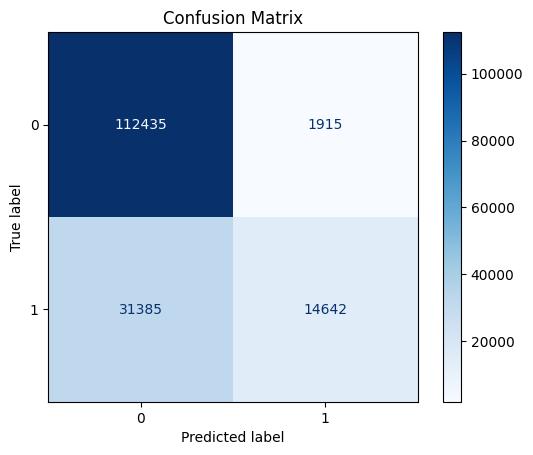

In [ ]:
# Evaluate the model
evaluate_model(trained_model, X_test, y_test, num_classes)

In [ ]:
# Save the trained model
trained_model.save('Model-1')
print("Model saved successfully.")

INFO:tensorflow:Assets written to: Model-1\assets


INFO:tensorflow:Assets written to: Model-1\assets


Model saved successfully.
